In [20]:
import pandas as pd, numpy as np, mglearn, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px,umap
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tqdm import tqdm
from matplotlib.pyplot import *
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, normalize

/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

2023-02-05 12:47:14.004956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 12:47:15.165581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tylman/anaconda3/envs/ketsu/lib/
2023-02-05 12:47:15.165706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnv

In [32]:

#Preparing data
train_data = pd.read_csv('Data/spam_train.csv',index_col=0).reset_index(drop=True)
test_data = pd.read_csv('Data/spam_test.csv',index_col=0).reset_index(drop=True)
XCOL = train_data.columns.drop('class')
YCOL = 'class'

#Preparing Necessary Variables
out_dir = Path('output')
res_dir = Path('results')
res_dir.mkdir(exist_ok=True)
train_model = True
save = False
train_data

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.07,0.00,0.07,0.0,0.00,0.00,0.00,0.46,0.69,0.00,...,0.142,0.175,0.032,0.000,0.021,0.000,3.007,60,791,0
1,0.00,0.00,0.74,0.0,1.85,0.37,0.37,0.00,0.00,0.74,...,0.000,0.264,0.000,0.000,0.000,0.000,2.492,12,172,1
2,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.763,0.000,2.181,6,24,0
3,0.00,0.00,0.32,0.0,0.65,0.65,0.32,0.32,0.00,0.00,...,0.000,0.105,0.000,0.000,0.158,0.000,1.494,10,139,1
4,1.03,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.176,0.176,0.000,2.766,26,83,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1,4,0
3446,0.00,0.58,0.58,0.0,0.00,0.00,0.00,0.58,0.58,7.55,...,0.000,0.192,0.000,0.192,0.000,0.096,1.526,10,58,1
3447,0.00,0.71,0.35,0.0,0.35,0.00,0.00,0.00,0.00,0.00,...,0.000,0.058,0.000,0.700,0.000,0.000,3.768,61,260,1
3448,0.54,0.13,0.38,0.0,0.05,0.19,0.00,0.05,0.35,0.16,...,0.000,0.086,0.000,0.273,0.150,0.159,6.789,195,3327,1


In [6]:
#General Functions
def ty_normalize(train_df,test_df):
    train, test = train_df.copy(), test_df.copy()
    scaler = StandardScaler()
    scaler.fit(train[XCOL])
    train[XCOL] = normalize(scaler.transform(train[XCOL]))
    test[XCOL] = normalize(scaler.transform(test[XCOL]))
    return train, test

def make_df(model_list,opt_list):
    #Edited from my final last semester for simpler models
    #Since not all models require the same option lists, we can run this on each pairing and merge.
    result = []
    for model_gen in model_list:
        for option in opt_list:
            model_id, model = model_gen(option)
            result.append([f'{model_id}_{option:.2f}', model_id, model,option])
    return pd.DataFrame(columns = ['ID','Model_ID','Model', 'Attribute'],data=result)


def knn(neighbor):
    return inspect.stack()[0][3], KNeighborsClassifier(n_neighbors=int(neighbor)) #I know this can cause issues, but it's worth it for this.
def logistic(C):
    return inspect.stack()[0][3], LogisticRegression(C=C)
def svm(C):
    return inspect.stack()[0][3], SVC(C=C,probability=True,kernel='linear')

def basic_analysis(model, train_data,test_data):
    #Normalize data beforehand
    model.fit(train_data[XCOL],train_data[YCOL])
    return [model.score(train_data[XCOL],train_data[YCOL]),model.score(test_data[XCOL],test_data[YCOL])]

    

def cval(row, train_data, test_data, save=False, outdir=''):
    #Need to normalize inside of here for the cval splits
    cval_res = pd.DataFrame.from_dict(cross_validate(row['Model'], train_data[XCOL],train_data[YCOL], cv=5,return_train_score=True))
    cval_res = cval_res[['train_score','test_score']].reset_index().rename(columns={"index":"Split","train_score":"train","test_score":"test"})
    cval_res['Model_ID'] = row['Model_ID']
    cval_res['Attribute'] = row['Attribute']
    if save:
        out = Path(outdir,row['Model_ID'],row['ID'])
        if not out.is_dir():
            out.mkdir(parents=True)
        cval_res.to_csv(Path(out,'cval.csv'),index=False)
        cval_res.style.to_latex(Path(out,'cval.tex'))
    # test_result = cval_result['test_score']
    # train_result = cval_result['train_score']
    return cval_res
    # return test_result, train_result
    

    
    

#Create a scatterplot of train/test accuracy for each of the 5 folds for each model/option pair 
#Bruh just use the cross_val_predict/cross_val_score option.







In [7]:
train, test = ty_normalize(train_data,test_data)

log_options = np.linspace(0,10,101)[1:]
svm_options = np.linspace(0,10,101)[1:]
neighbors = np.arange(2,101)


model_df = pd.concat([make_df([knn],neighbors),make_df([svm],svm_options),make_df([logistic],log_options)])
model_df

,ID,Model_ID,Model,Attribute
0,knn_2.00,knn,KNeighborsClassifier(n_neighbors=2),2.0
1,knn_3.00,knn,KNeighborsClassifier(n_neighbors=3),3.0
2,knn_4.00,knn,KNeighborsClassifier(n_neighbors=4),4.0
3,knn_5.00,knn,KNeighborsClassifier(),5.0
4,knn_6.00,knn,KNeighborsClassifier(n_neighbors=6),6.0
...,...,...,...,...
95,logistic_9.60,logistic,LogisticRegression(C=9.600000000000001),9.6
96,logistic_9.70,logistic,LogisticRegression(C=9.700000000000001),9.7
97,logistic_9.80,logistic,LogisticRegression(C=9.8),9.8
98,logistic_9.90,logistic,LogisticRegression(C=9.9),9.9


In [29]:
if train_model:
    res = pd.concat([cval(row,train,test, save=save, outdir=out_dir) for _,row in tqdm(model_df.iterrows(),total=model_df.shape[0])]).reset_index(drop=True)
else:
    res = pd.read_csv(Path(res_dir,'full_results.csv'))

In [30]:
grouped = res.groupby(["Model_ID","Attribute"])[['train','test']]

In [31]:
def seaborn_friendly(res):
    train_only = res.drop(columns='test').rename(columns={"train":"Accuracy"})
    train_only['type'] = 'train'
    test_only = res.drop(columns='train').rename(columns={"test":"Accuracy"})
    test_only['type'] = 'test'
    return pd.concat([train_only, test_only]).reset_index(drop=True)
def plot_analysis(res, save=False, outdir='.'):
    analyzed = res.groupby(["Model_ID","Attribute"])[['train','test']].agg([np.mean,np.std])
    analyzed.columns = ['_'.join(col) for col in analyzed.columns.values]
    analyzed.reset_index(inplace=True)
    best = get_best(analyzed)
    if save:
        best.to_csv(Path(outdir,"Best.csv"))
        analyzed.to_csv(Path(outdir,"Processed_results.csv"),index=False)
        res.to_csv(Path(outdir,"full_results.csv"),index=False)
        best.to_latex(Path(outdir,"Best.tex"))
        analyzed.to_latex(Path(outdir,"Processed_results.tex"),index=False)
        res.to_latex(Path(outdir,"full_results.tex"),index=False)
    ax = sns.scatterplot(x='train_mean',y='test_mean',data=analyzed, hue="Model_ID")
    ax.set(title="Overall Performance By Model")
    if save:
        ax.get_figure().savefig(Path(outdir,"Full_Scatter.png"))
    show()
    sea = seaborn_friendly(res)
    for name, group in sea.groupby("Model_ID"):
        ax = sns.lineplot(data=group, x="Attribute",y="Accuracy",hue="type",errorbar="sd")
        ax.set(title="{} Performance".format(name))
        show()
        if save:
            ax.get_figure().savefig(Path(outdir,"{}_Performance.png".format(name)))
    return best
    
def get_best(data):
    return data.iloc[data.groupby("Model_ID")["test_mean"].idxmax()]

def make_best_apply(row,**kwargs):
    lazy_dict = {'logistic':logistic,'knn':knn,'svm':svm}
    func = lazy_dict[row['Model_ID']](row['Attribute'])[1]
    func.fit(kwargs['train_data'][XCOL],kwargs['train_data'][YCOL])
    return pd.Series(index = ['Model_ID','Attribute','Final_Perf','Cval_Perf','Model'],data = [row['Model_ID'],row['Attribute'],func.score(kwargs['test_data'][XCOL],kwargs['test_data'][YCOL]),row['test_mean'],func])



def test_result(df,test,train, save=False, outdir=''):
    final = df.apply(make_best_apply,axis=1,test_data=test,train_data=train)
    
    if save:
        final.drop(columns=['Model']).to_csv(Path(outdir,"Final.csv"),index=False)
        final.drop(columns=['Model']).to_latex(Path(outdir,"Final.tex"),index=False)
    return final
    

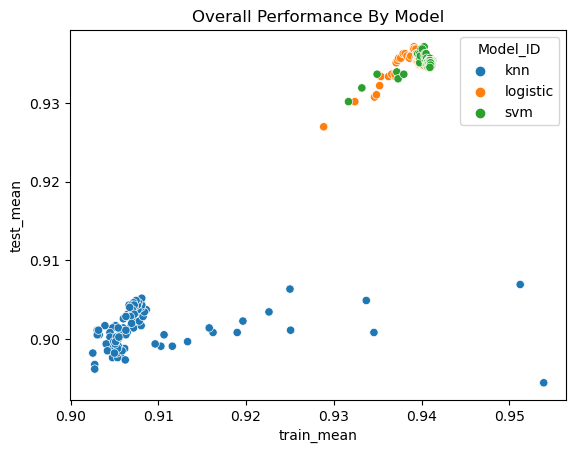

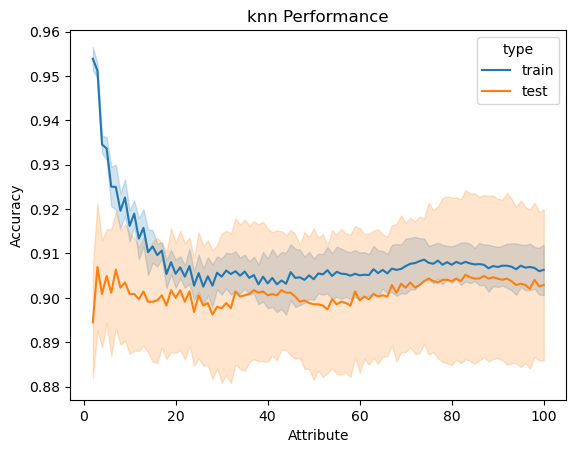

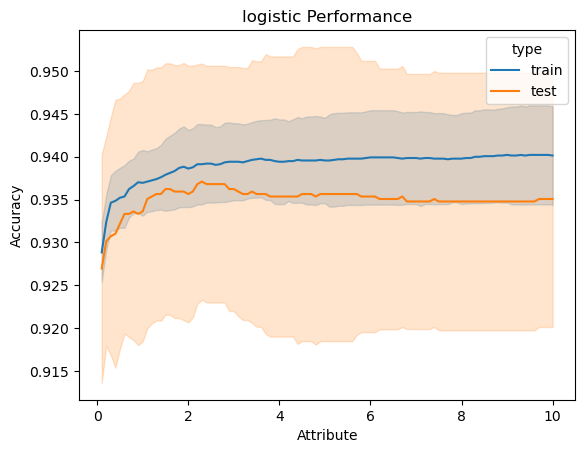

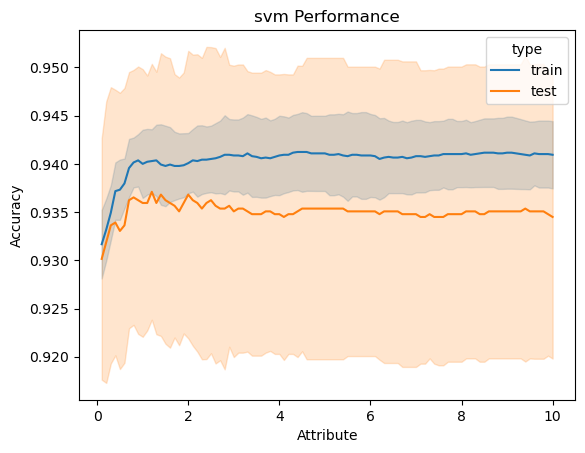

,Model_ID,Attribute,Final_Perf,Cval_Perf,Model
1,knn,3.0,0.895743,0.906957,KNeighborsClassifier(n_neighbors=3)
121,logistic,2.3,0.925282,0.937101,LogisticRegression(C=2.3000000000000003)
210,svm,1.2,0.919201,0.937101,"SVC(C=1.2000000000000002, kernel='linear', pro..."


In [33]:
best = plot_analysis(res,save=save,outdir=res_dir)
final = test_result(best,test,train,save=save, outdir=res_dir)
final

In [49]:

#Get called/truth binary data into a df, and the class score value into a df. Plot the 3 different classes into 3D
def missed_prep(final,test,save=False,outdir='.'):
    missed_df = pd.DataFrame(columns=final['Model_ID'])
    missed_df['truth'] = test[YCOL]
    missed_df['truth_map'] = missed_df['truth'].map({0:'Safe',1:'Spam'})
    score_df = missed_df.copy()
    for idx, row in final.iterrows():
        func = row['Model']
        name = row['Model_ID']
        predictions = func.predict_proba(test[XCOL])
        score_df[name] = predictions[:,1]
        missed_df[name] = predictions.argmax(axis=1)
    if save:
        score_df.to_csv(Path(outdir,'scores.csv'))
        missed_df.to_csv(Path(outdir,'binary_result.csv'))
    return missed_df, score_df

def plot_misses(scores, save=False, outdir = '.'):
    fig = px.scatter_3d(scores,x='knn',y='logistic',z='svm',color='truth_map',hover_name=scores.index)
    if save:
        plotly.offline.plot(fig, filename=str(Path(outdir,'Scores_Plot_3d.html')),auto_open=False)
    return fig

def plot_importance(final, save=False, outdir = '.'):
    for idx, row in final.iterrows():
        if row['Model_ID'] != 'knn':
            fig = figure() 
            data = pd.DataFrame(index= XCOL,data = np.abs(row['Model'].coef_.flatten()), columns=['Importance']).sort_values('Importance',ascending=False)
            data.index.name = 'Feature'
            ax = data['Importance'].plot.bar(title='{} Feature Coefficient Magnitude'.format(row['Model_ID']))
            # map(lambda p: p.set_fontsize(5), ax.get_xticklabels()) #Literally no amount of shrinking is helping
            if save:
                fig.savefig(Path(outdir,'{}_features.png'.format(row['Model_ID'])),bbox_inches='tight')
                data.to_csv(Path(outdir,'{}_features.csv'.format(row['Model_ID'])))
                data.iloc[:5].to_latex(Path(outdir,'{}_features.tex'.format(row['Model_ID'])))
            show()


/tmp/ipykernel_544/3347045349.py:35: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



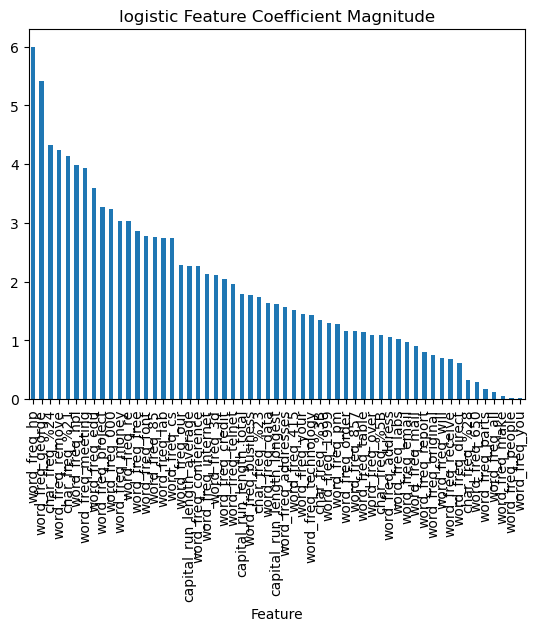

/tmp/ipykernel_544/3347045349.py:35: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



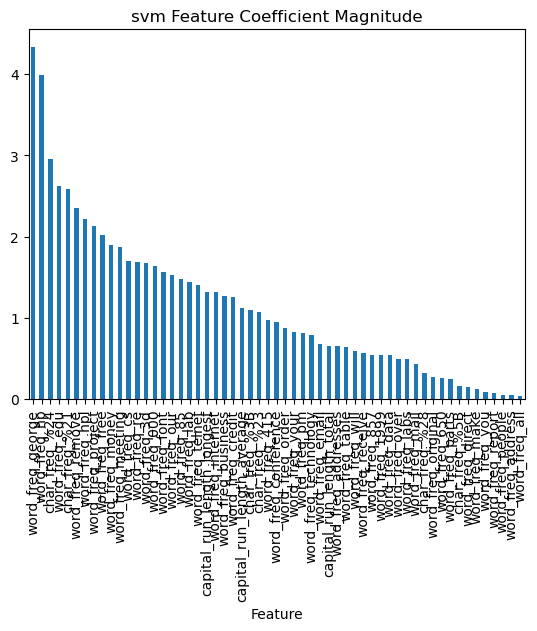

In [50]:
binary, scores = missed_prep(final,test,save=True,outdir=res_dir)
plot_misses(scores,save=True,outdir=res_dir)
plot_importance(final,save=True,outdir=res_dir)

In [54]:
test.iloc[[1131,1033]]

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
1131,-0.130909,-0.061125,-0.203864,-0.014953,-0.168926,-0.124212,-0.104786,-0.095935,-0.119525,-0.146048,...,-0.059531,0.288620,-0.055549,-0.144202,-0.123213,-0.038566,-0.023516,-0.026864,-0.105356,1
1033,-0.041992,-0.019607,-0.065393,-0.004797,-0.054187,-0.039844,0.632852,0.618191,-0.038340,-0.046848,...,-0.019096,0.218138,-0.017818,-0.046256,0.318220,-0.012371,-0.002913,-0.015798,-0.046866,0


In [26]:
def umap_plot_3d(train,test,save=False, outdir='.'):
    UMAP = umap.UMAP(n_components=3)
    UMAP.fit(train[XCOL].values)
    train_temp = pd.DataFrame(columns=['x','y','z'],data=UMAP.transform(train[XCOL]))
    train_temp['Class'] = train[YCOL].map({0:'Safe',1:'Spam'})
    test_temp = pd.DataFrame(columns=['x','y','z'],data=UMAP.transform(test[XCOL]))
    test_temp['Class'] = ['False_Positive','False_Negative']
    plotable = pd.concat([train_temp,test_temp])

    fig = px.scatter_3d(plotable,x='x',y='y',z='z',color='Class')
    if save:
        plotly.offline.plot(fig, filename=str(Path(outdir,'UMAP_Plot.html')),auto_open=False)
    return fig

In [27]:

umap_plot_3d(train,test.iloc[[1131,1033]],save = True, outdir=res_dir)

In [34]:
final['Cval_Perf'] - final['Final_Perf']

1      0.011214
121    0.011819
210    0.017901
dtype: float64

In [37]:
svm_feat = pd.read_csv('results/svm_features.csv')
lr_feat = pd.read_csv('results/logistic_features.csv')

In [38]:
svm_feat

,\begin{tabular}{r}
0,\toprule
1,0 \\
2,\midrule
3,4.331504 \\
4,3.990053 \\
5,2.951851 \\
6,2.625116 \\
7,2.582081 \\
8,\bottomrule
9,\end{tabular}
